In [5]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools

import matplotlib as mpl

warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

In [6]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
results_dir = os.path.join(output_dir, 'sfp_model', 'results_2D')
fig_dir = os.path.join(output_dir, 'figures', 'sfp_model', 'results_2D')
lr = 0.0005
max_epoch = 30000
dset='nsdsyn'
roi_list = ['V1','V2','V3']
vsc='pRFsize'
nsd_subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
broderick_sn_list = [1, 6, 7, 45, 46, 62, 64, 81, 95, 114, 115, 121]
broderick_subj_list = [utils.sub_number_to_string(i, 'broderick') for i in broderick_sn_list]
ARGS_2D = ['sub','lr','eph','roi']

# NSD 
## model

In [7]:
pt_file_list = []
dset = 'nsdsyn'
for subj, roi in itertools.product(nsd_subj_list, ['V1','V2','V3']):
    file_name = os.path.join(results_dir, dset, 'corrected', f'model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
    pt_file_list.append(file_name)
nsd_params = model.load_all_models(pt_file_list, *ARGS_2D)

precision_s =  pd.read_csv(os.path.join(output_dir, 'dataframes', dset, 'precision', 'corrected', f'precision-s_dset-{dset}_vs-pRFsize.csv'))
nsd_df = pd.merge(nsd_params, precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])

# Broderick et al
## model

In [8]:
pt_file_list = []
dset = 'broderick'
tfunc_types=['uncorrected']
for subj, roi, tfunc in itertools.product(broderick_subj_list, ['V1'], tfunc_types):
    file_name = os.path.join(output_dir, 'before_w_a_correction', 'sfp_model', 'results_2D',  dset, f'tfunc-{tfunc}_model_lr-{lr}_eph-{max_epoch}_dset-{dset}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
    pt_file_list.append(file_name)
broderick_params = model.load_all_models(pt_file_list, *ARGS_2D+['tfunc'])
broderick_params.replace({'tfunc': {'derick/tfunc corrected': 'corrected', 'derick/tfunc uncorrected': 'uncorrected'}}, inplace=True)

broderick_precision_s =  pd.read_csv(os.path.join(output_dir, 'before_w_a_correction', 'dataframes', dset, 'precision', f'precision-s_dset-{dset}_vs-pRFsize.csv'))
broderick_df = pd.merge(broderick_params, broderick_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])

## broderick precision

In [9]:
nsd_df['dset_type'] = nsd_df['vroinames'].apply(lambda x: f'NSD {x}')
nsd_df['dset'] = 'nsdsyn'
broderick_df['dset_type'] = 'Broderick et al. V1'

final_df = pd.concat((broderick_df, nsd_df), axis=0)

final_df['goal'] = final_df['vroinames'].apply(lambda x: 'Replication' if x == "V1" else 'Extension')

tmp = final_df.query('"NSD V1" in dset_type')
tmp['goal'] = 'Extension'
final_df = pd.concat((tmp, final_df), axis=0)


# Weighted-mean for each parameter

In [11]:
PARAMS_2D = ['sigma', 'slope', 'intercept', 'p_1', 'p_2', 'p_3', 'p_4', 'A_1', 'A_2']
utils.calculate_weighted_mean(final_df, PARAMS_2D, 'precision', groupby=['dset_type','goal'])

,dset_type,goal,sigma,slope,intercept,p_1,p_2,p_3,p_4,A_1,A_2
0,Broderick et al. V1,Replication,2.274352,0.115475,0.371032,0.070086,-0.027745,0.058010,-0.004963,0.045074,-0.004617
1,NSD V1,Extension,2.199299,0.150471,0.171367,0.080991,-0.021897,-0.036557,-0.065930,0.057589,-0.019375
2,NSD V1,Replication,2.199299,0.150471,0.171367,0.080991,-0.021897,-0.036557,-0.065930,0.057589,-0.019375
3,NSD V2,Extension,3.797996,0.171325,0.253642,0.161812,-0.102574,-0.342089,0.039329,0.046426,-0.024967
4,NSD V3,Extension,4.461167,0.167584,0.202358,0.051839,-0.046833,-0.463685,0.042397,0.043957,-0.012346


# Plot parameter estimates

(<Figure size 1857.6x324 with 5 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

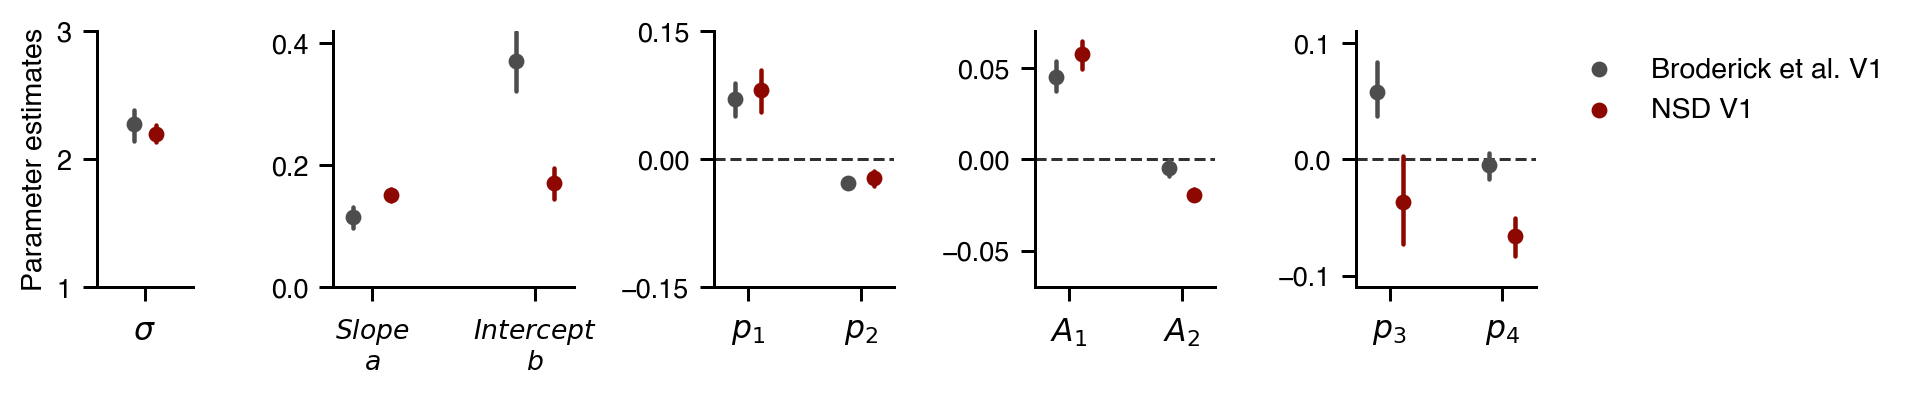

In [20]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_df, 'Replication')
ylim_list = [(1, 3), (0, 0.42), (-0.2, 0.2),(-0.1, 0.1), (-0.2, 0.2)]
yticks_list=  [[1,2,3], [0, 0.2, 0.4], [-0.2,0,0.2], [-0.1,0,0.1], [-0.2,0,0.2]]
params_list = [['sigma'], ['slope', 'intercept'], ['p_1', 'p_2'], ['A_1', 'A_2'], ['p_3', 'p_4']]
title_list = ['Bandwidth', 'Eccentricity effect', 'Absolute orientation effect\non preferred period', 'Amplitude', 'Relative orientation effect\non preferred period']
vis2D.make_param_summary_fig(tmp, 'dset_type', ['Broderick et al. V1', 'NSD V1'], pal, 
                           params_list, ylim_list, yticks_list, title_list=None,
                           width_ratios=(0.8,2,1.5,1.5,1.5), fig_size=(8.6, 1.5),
                           scale=0.9, errwidth=1.5,
                           save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'replication','goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))
#g.margins(x=0.1)

(<Figure size 1857.6x324 with 5 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

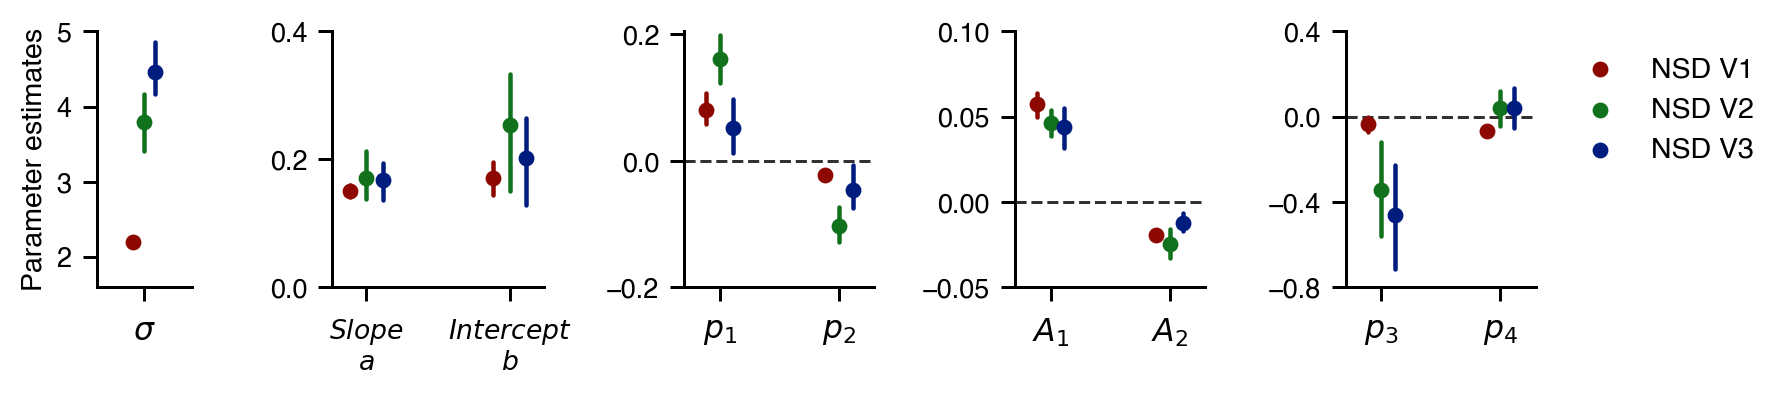

In [21]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_df, 'extension')
ylim_list = [(1.6, 5), (0, 0.4), (-0.2, 0.205),(-0.05, 0.1), (-0.8, 0.4)]
yticks_list=  [[2, 3, 4, 5], [0, 0.2, 0.4], [-0.2,0,0.2], [-0.05,0,0.05,0.1], [-0.8,-0.4,0,0.4]]
params_list = [['sigma'], ['slope', 'intercept'], ['p_1', 'p_2'], ['A_1', 'A_2'], ['p_3', 'p_4']]
title_list = ['Bandwidth', 'Eccentricity effect', 'Absolute orientation effect\non preferred period', 'Amplitude', 'Relative orientation effect\non preferred period']
vis2D.make_param_summary_fig(tmp, 'dset_type', hue_order, pal, 
                           params_list, ylim_list, yticks_list, title_list=None,
                           width_ratios=(0.9,2,1.8,1.8,1.8), fig_size=(8.6, 1.5),
                           scale=0.9, errwidth=1.5,
                           save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'extension','goal-extension_lr-0.0005_eph-30000_vs-pRFsize.svg'))